# Static Analysis

When we consider static quantities, we can get information from the magnetization of the antiferromagnetic state $ m_{AF}^2 $ (that corresponds to the static structure factor at $\vec{q}_{\pi,\pi}$) and from the striped state $ m_{STR}^2 $ (that corresponds to the static structure factor at $\vec{q}_{0,\pi}$ ). We want a driagram of these two quantities versus the value of $J_2/J_1$. These quantities are given by the following equations:
$$ m_{AF}^2 = \frac{8}{N(N+4)} \left[ \sum_{\alpha} \sum_{i, j\in \alpha} \langle \mathbf{S}_i \cdot \mathbf{S}_j \rangle \right]_J $$ 
$$ m_{STR}^2 = \frac{4}{N(N+4)} \left[ \sum_{\nu} \sum_{\alpha_{\nu}} \sum_{i,j \in \alpha} \langle \mathbf{S}_i \cdot \mathbf{S}_j \rangle \right]_J $$

We obtain from the code the value of these two quantities for each disorder realization. The file contains two columns, the first one corresponds to $m_{AF}^2$ and the second one, to $m_{STR}^2$.

In [1]:
import numpy as np
import cmath as m
import matplotlib.pyplot as plt
import csv
import scipy.stats
from mpl_toolkits.mplot3d import axes3d
from matplotlib.collections import PolyCollection
#%matplotlib notebook

### Parameters

In [2]:
# Lattice

dim      = 2              # Dimension of the lattice
rep      = 200            # Disorder realizations
nev      = 200            # Number of excited states used

nspins   = [24] #,32,36]  # Number of spins in the system
nsp      = len(nspins)  

In [3]:
# Hamiltonian parameters

J1           = 1.0      # Nearest neighbours coupling
D1           = 0.0      # Nearest neighbours anisotropy
D2           = 0.0      # Next-nearest neighbours anisotropy

# Next-nearest neighbours coupling
J2           = [0.40,0.44,0.50,0.54,0.60,0.64,0.70]

# Strength of the disorder
dis_strength = [0.0,0.2,0.4,0.6,0.8,1.0]
#dis_strength = [0.0, 0.5, 1.0, 1.5, 2.0, 3.0]
#dis_strength = [0.0,0.1,0.2,0.3,0.4,0.5]

nJ2          = len(J2)
ndis_str     = len(dis_strength)

In [4]:
root        = '/home/ale/MAIN24/'

pathINdata  = np.empty((ndis_str,nsp,nJ2),dtype=object)
pathOUTdata = np.empty((ndis_str,nsp,nJ2),dtype=object)

for d in range(ndis_str):
    for n in range(nsp):    
        for j in range(nJ2):
            pathINdata[d,n,j]  = root + 'dis' + str(dis_strength[d]) + '/' + str(nspins[n]) + 'nnn' + "{:2.2f}".format(J2[j]) + '/'
            pathOUTdata[d,n,j] = root + 'dis' + str(dis_strength[d]) + '/' + str(nspins[n]) + 'nnn' + "{:2.2f}".format(J2[j]) + '/'
            #pathINdata[d,n,j]  = '/home/ale/SKL_RUNS/dis' + str(dis_strength[d]) + '/' + str(nspins[n]) + 'nnn' + "{:2.2f}".format(J2[j]) + '/'
            #pathOUTdata[d,n,j] = '/home/ale/SKL_RUNS/dis' + str(dis_strength[d]) + '/' + str(nspins[n]) + 'nnn' + str(J2[j]) + '/'

### Prepare (full) data

In [5]:
tmp_mAF  = np.empty((ndis_str,nsp,nJ2,rep))
tmp_mSTR = np.empty((ndis_str,nsp,nJ2,rep))

for d in range(ndis_str):
    for n in range(nsp):
        for j in range(nJ2):
            with open(pathINdata[d,n,j] + 'mag.dat') as INfile:
                array = np.genfromtxt(INfile)
                tmp_mAF[d,n,j,:], tmp_mSTR[d,n,j,:] = array.T
                
                
# Cumulative values
check_mAF  = np.zeros((ndis_str,nsp,nJ2,rep))
check_mSTR = np.zeros((ndis_str,nsp,nJ2,rep))

for dis_rep in range(rep):
    check_mAF[:,:,:,dis_rep]  = check_mAF[:,:,:,dis_rep-1] + tmp_mAF[:,:,:,dis_rep]
    check_mSTR[:,:,:,dis_rep] = check_mSTR[:,:,:,dis_rep-1] + tmp_mSTR[:,:,:,dis_rep]
    
for dis_rep in range(1,rep):
    check_mAF[:,:,:,dis_rep]  /= (dis_rep+1)
    check_mSTR[:,:,:,dis_rep] /= (dis_rep+1)

### Prepare (reduced) data

In [6]:
# Data
mAF  = np.empty((ndis_str,nsp,nJ2))
mSTR = np.empty((ndis_str,nsp,nJ2))

mAF  = np.sum(tmp_mAF, axis=3)/rep
mSTR = np.sum(tmp_mSTR, axis=3)/rep


# Error
mAF_err  = np.empty((ndis_str,nsp,nJ2,4))
mSTR_err = np.empty((ndis_str,nsp,nJ2,4))

for d in range(1,ndis_str):
    for n in range(nsp):
        for j in range(nJ2):
            histAF, binsAF = np.histogram(tmp_mAF[d,n,j,:], bins=32, density=True)
            mAF_err[d,n,j,0:2] = scipy.stats.norm.fit(tmp_mAF[d,n,j,:])
            mAF_err[d,n,j,2:4] = scipy.stats.cauchy.fit(tmp_mAF[d,n,j,:])
            
            histSTR, binsSTR = np.histogram(tmp_mSTR[d,n,j,:], bins=32, density=True)
            mSTR_err[d,n,j,0:2] = scipy.stats.norm.fit(tmp_mSTR[d,n,j,:])
            mSTR_err[d,n,j,2:4] = scipy.stats.cauchy.fit(tmp_mSTR[d,n,j,:])

### Plot vs J2

[ 5.62743023e-04 -7.43334725e-04 -5.64959079e-04 -1.04783726e-03
 -4.74051783e-04 -2.23099886e-04  3.29687389e-05]
[ 0.00202678 -0.00219406 -0.00371486 -0.00377572 -0.00099809 -0.00067212
  0.00021596]
[ 0.00146403 -0.00145073 -0.0031499  -0.00272789 -0.00052404 -0.00044902
  0.00018299]
[ 0.00620755 -0.00541716 -0.01096412 -0.00820634 -0.00375482 -0.00078245
  0.00096196]


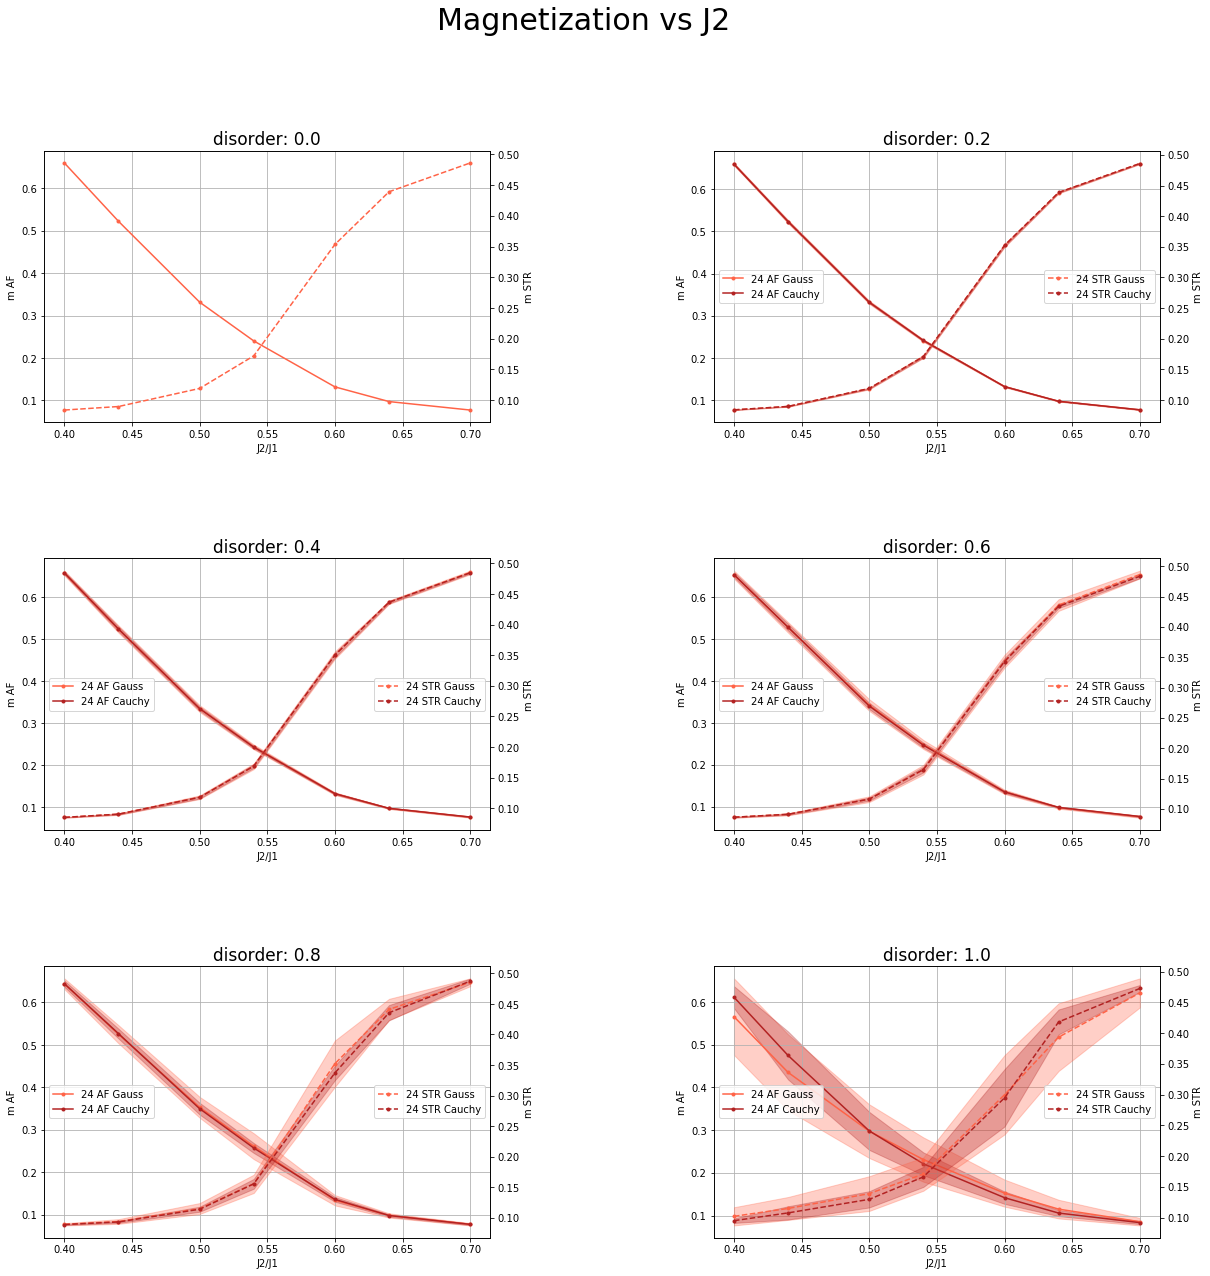

In [13]:
# Colors
col_norm    = ['tomato','mediumseagreen','goldenrod','royalblue']
col_cauchy  = ['firebrick','darkgreen','orange','navy']

fig, ax1 = plt.subplots(3,2,gridspec_kw={'wspace':0.5, 'hspace': 0.5},figsize=(20,20))
fig.suptitle("Magnetization vs J2", fontsize=30)

print(mAF[0,0,:]-mAF[1,0,:])
print(mAF[0,0,:]-mAF[2,0,:])
print(mAF[1,0,:]-mAF[2,0,:])
print(mAF[0,0,:]-mAF[3,0,:])


for x in range(3):
    for y in range(2):
        ax1[x,y].set_title("disorder: " + str(dis_strength[x*2+y]), fontsize=17)
        ax1[x,y].set_xlabel("J2/J1")
        ax1[x,y].set_ylabel("m AF")
        ax1[x,y].grid()
        ax2= ax1[x,y].twinx()
        ax2.set_ylabel("m STR")

        for n in range(nsp):
            
            if x == 0 and y == 0:
                ax1[x,y].plot(J2,mAF[x*2+y,n,:],col_norm[n],marker='.',ls='-',label=str(nspins[n])+' AF')
                ax2.plot(J2,mSTR[x*2+y,n,:],col_norm[n],marker='.',ls='--',label=str(nspins[n])+' STR')
            
            else:
                #ax1[x,y].plot(J2,mAF[x*2+y,n,:],'blue',marker='.',ls='-',label=str(nspins[n])+' AF')
                ax1[x,y].plot(J2,mAF_err[x*2+y,n,:,0],col_norm[n],marker='.',ls='-',label=str(nspins[n])+' AF Gauss')
                ax1[x,y].fill_between(J2,mAF_err[x*2+y,n,:,0]-mAF_err[x*2+y,n,:,1],mAF_err[x*2+y,n,:,0]+mAF_err[x*2+y,n,:,1],alpha=0.3,color=col_norm[n])
                ax2.plot(J2,mSTR_err[x*2+y,n,:,0],col_norm[n],marker='.',ls='--',label=str(nspins[n])+' STR Gauss')
                ax2.fill_between(J2,mSTR_err[x*2+y,n,:,0]-mSTR_err[x*2+y,n,:,1],mSTR_err[x*2+y,n,:,0]+mSTR_err[x*2+y,n,:,1],alpha=0.3,color=col_norm[n])

                #ax2.plot(J2,mSTR[x*2+y,n,:],'blue',marker='.',ls='--',label=str(nspins[n])+' STR')
                ax1[x,y].plot(J2,mAF_err[x*2+y,n,:,2],col_cauchy[n],marker='.',ls='-',label=str(nspins[n])+' AF Cauchy')
                ax1[x,y].fill_between(J2,mAF_err[x*2+y,n,:,2]-mAF_err[x*2+y,n,:,3],mAF_err[x*2+y,n,:,2]+mAF_err[x*2+y,n,:,3],alpha=0.3,color=col_cauchy[n])
                ax2.plot(J2,mSTR_err[x*2+y,n,:,2],col_cauchy[n],marker='.',ls='--',label=str(nspins[n])+' STR Cauchy')
                ax2.fill_between(J2,mSTR_err[x*2+y,n,:,2]-mSTR_err[x*2+y,n,:,3],mSTR_err[x*2+y,n,:,2]+mSTR_err[x*2+y,n,:,3],alpha=0.3,color=col_cauchy[n])

                ax1[x,y].legend(loc='center left')
                ax2.legend(loc='center right')

plot_name = root + 'plots/mag_smallDis.pdf'
        
fig.savefig(plot_name)

### Check distribution of data

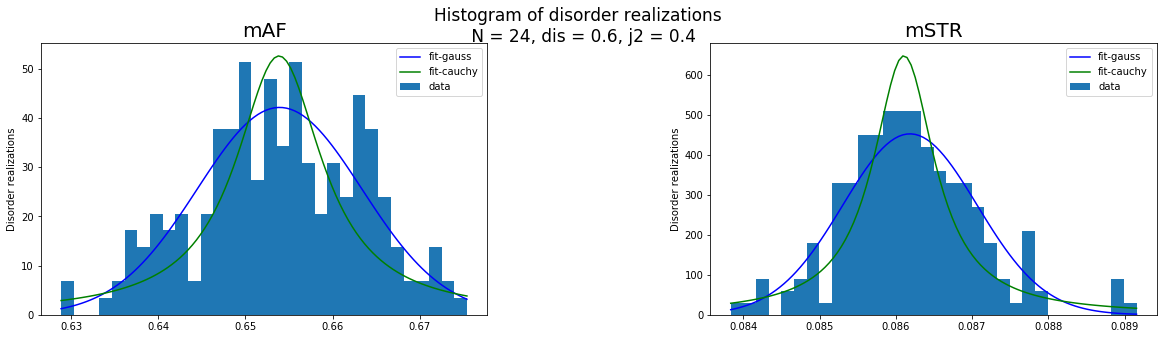

In [8]:
this_spin = 0
this_dis  = 3
this_j2   = 0

title = "Histogram of disorder realizations \n N = " + str(nspins[this_spin]) + ', dis = ' + str(dis_strength[this_dis]) + ', j2 = ' + str(J2[this_j2])

# Check histogram
fig, ax = plt.subplots(1,2,gridspec_kw={'wspace':0.5, 'hspace': 0.5}, figsize=(20,5))
fig.suptitle(title, fontsize=17)

ax[0].set_title("mAF", fontsize=20)
ax[0].set_ylabel("Disorder realizations")
ax[1].set_title("mSTR", fontsize=20)
ax[1].set_ylabel("Disorder realizations")

histAF, binsAF, patchesAF    = ax[0].hist(tmp_mAF[this_dis,this_spin,this_j2,:], bins=32, density=True,label="data")
histSTR, binsSTR, patchesSTR = ax[1].hist(tmp_mSTR[this_dis,this_spin,this_j2,:], bins=32, density=True,label="data")

# Fit the distribution
meanAF, varAF = scipy.stats.norm.fit(tmp_mAF[this_dis,this_spin,this_j2,:])
xAF = np.linspace(binsAF[0],binsAF[32],100)
pAF = scipy.stats.norm.pdf(xAF,meanAF,varAF)
ax[0].plot(xAF,pAF,'k',label='fit-gauss',color='b')
ax[0].legend()
#ax[0].text(0.3,20,'mean: {:2.4f}'.format(meanAF) + '\n' + 'std: {:2.4f}'.format(m.sqrt(varAF).real))

meanAF, stdAF = scipy.stats.cauchy.fit(tmp_mAF[this_dis,this_spin,this_j2,:])
xAF = np.linspace(binsAF[0],binsAF[32],100)
pAF = scipy.stats.cauchy.pdf(xAF,meanAF,stdAF)
ax[0].plot(xAF,pAF,'k',label='fit-cauchy',color='g')
ax[0].legend()
#ax[0].text(0.3,20,'mean: {:2.4f}'.format(meanAF) + '\n' + 'std: {:2.4f}'.format(m.sqrt(varAF).real))

meanSTR, varSTR = scipy.stats.norm.fit(tmp_mSTR[this_dis,this_spin,this_j2,:])
xSTR = np.linspace(binsSTR[0],binsSTR[32],100)
pSTR = scipy.stats.norm.pdf(xSTR,meanSTR,varSTR)
ax[1].plot(xSTR,pSTR,'k',label="fit-gauss",color='b')
ax[1].legend()
#ax[1].text(0.25,25,'mean: {:2.4f}'.format(meanSTR) + '\n' + 'std: {:2.4f}'.format(m.sqrt(varSTR).real))

meanSTR, stdSTR = scipy.stats.cauchy.fit(tmp_mSTR[this_dis,this_spin,this_j2,:])
xSTR = np.linspace(binsSTR[0],binsSTR[32],100)
pSTR = scipy.stats.cauchy.pdf(xSTR,meanSTR,stdSTR)
ax[1].plot(xSTR,pSTR,'k',label='fit-cauchy',color='g')
ax[1].legend()
#ax[1].text(0.3,20,'mean: {:2.4f}'.format(meanAF) + '\n' + 'std: {:2.4f}'.format(m.sqrt(varAF).real))

plot_name = root + 'plots/distrib.pdf'
        
fig.savefig(plot_name)

### Check convergibility

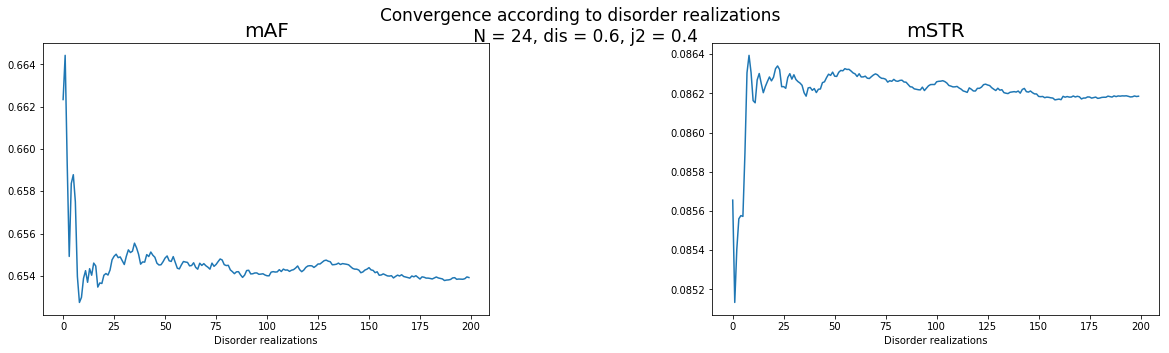

In [9]:
# Plot the cummulative values
d = np.linspace(0,rep-1,rep)

title = "Convergence according to disorder realizations \n N = " + str(nspins[this_spin]) + ', dis = ' + str(dis_strength[this_dis]) + ', j2 = ' + str(J2[this_j2])

fig, ax = plt.subplots(1,2,gridspec_kw={'wspace':0.5, 'hspace': 0.5}, figsize=(20,5))
fig.suptitle(title,fontsize=17)

ax[0].set_title("mAF", fontsize=20)
ax[0].set_xlabel("Disorder realizations")
ax[0].plot(d,check_mAF[this_dis,this_spin,this_j2,:])
ax[1].set_title("mSTR", fontsize=20)
ax[1].set_xlabel("Disorder realizations")
ax[1].plot(d,check_mSTR[this_dis,this_spin,this_j2,:])

plot_name = root + 'plots/converg.pdf'
        
fig.savefig(plot_name)